<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/Camembert_LM%26TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 13.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 


In [ ]:
!pip install -Uq transformers
from fastai.text.all import *

     |████████████████████████████████| 2.3MB 14.4MB/s 
     |████████████████████████████████| 3.3MB 54.1MB/s 
     |████████████████████████████████| 901kB 48.9MB/s 


In [ ]:
# # better display of review text in dataframes
# pd.set_option('display.max_colwidth', None) 

# CamentBERT

CamemBERT, the BERT in French, was trained on 38GB of raw text on 256 GPUs (32 GB Tesla V100) for 1 day.

https://huggingface.co/camembert-base

https://huggingface.co/transformers/model_doc/roberta.html

In [ ]:
!pip install sentencepiece

from transformers import CamembertTokenizer, CamembertForCausalLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True)
model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True, add_cross_attention=True)

#transformers.RobertaForCausalLM.from_pretrained(pretrained_model_name_or_path='roberta-base', add_cross_attention=True, is_decoder=True, bos_token_id=<bos-id>, eos_token_id=<eos-id>)?

     |████████████████████████████████| 1.2MB 15.0MB/s 


Some weights of CamembertForCausalLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta.encoder.layer.11.crossattention.self.query.bias', 'roberta.encoder.layer.3.crossattention.self.query.bias', 'roberta.encoder.layer.2.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.4.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.8.crossattention.self.query.bias', 'roberta.encoder.layer.8.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.10.crossattention.output.dense.bias', 'roberta.encoder.layer.9.crossattention.self.query.bias', 'roberta.encoder.layer.9.crossattention.self.value.weight', 'roberta.encoder.layer.5.crossattention.self.query.bias', 'roberta.encoder.layer.6.crossattention.self.value.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1

NOTE: Language Modeling
- **Causal language modeling**: the model has to **predict the next token in the sentence** (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.
- **Masked language modeling**: the model has to **predict some tokens that are masked in the input**. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

In [ ]:
model.eval()

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Testing the tokenizer

Its always good to know what special tokens your tokenizer needs, lets have a look:

In [ ]:
# special tokens
tokenizer.special_tokens_map

{'additional_special_tokens': "['<s>NOTUSED', '</s>NOTUSED']",
 'bos_token': '<s>',
 'cls_token': '<s>',
 'eos_token': '</s>',
 'mask_token': '<mask>',
 'pad_token': '<pad>',
 'sep_token': '</s>',
 'unk_token': '<unk>'}

In [ ]:
tokenizer.vocab_size

32005

In [ ]:
ids = tokenizer.encode('Ce texte est affligeant, et')
ids

[5, 148, 930, 30, 5639, 1187, 17059, 7, 14, 6]

In [ ]:
# decoding
tokenizer.decode(ids)

'<s> Ce texte est affligeant, et</s>'

# Getting the data

In [ ]:
#creating a directory allocine
path = Path('/content/allocine/')
path.mkdir(parents=True, exist_ok=True)

In [ ]:
#creating a directory allocine
path = Path('/content/allocine/models')
path.mkdir(parents=True, exist_ok=True)

In [ ]:
path = Path('/content/allocine/'); path

Path('/content/allocine')

In [ ]:
# downloading the AlloCine dataset
!wget -q https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/raw/master/allocine_dataset/data.tar.bz2
!tar -xf /content/data.tar.bz2 -C '/content/allocine'

In [ ]:
train_df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=10000)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


NOTE: polarity: `0` negative review; `1` positive review

In [ ]:
val_df = pd.read_json(path/'data/val.jsonl', lines=True, nrows=1000)
val_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [ ]:
train_df.to_csv(path/'data/train.csv', encoding = 'utf-8', header = False, index = False)

In [ ]:
val_df.to_csv(path/'data/val.csv', encoding = 'utf-8', header = False, index = False)

In [ ]:
# training dataset
df_train = pd.read_csv(path/'data/train.csv', encoding = 'utf-8', header=None)
df_train.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0
1,http://www.allocine.fr/film/fichefilm-172430/critiques/spectateurs,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaine...",0


In [ ]:
# validation dataset
df_valid = pd.read_csv(path/'data/val.csv', encoding = 'utf-8', header=None)
df_valid.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0
1,http://www.allocine.fr/film/fichefilm-272/critiques/spectateurs,"The Wall a été réalisé par Alan Parker (Fame, Midnight Express, Evita) et Roger Waters (bassiste de Pink Floyd). Le film ne contient quasiment aucun dialogue, il s'agit en fait du double album conceptuel The Wall en images. Pink est une rock star déchue qui utilise tous les paradis artificiels possibles pour fuir le réel, mais cela ne fait que l'enfoncer encore plus dans son état sombre. Ce film est tout autant fascinant que dérangeant : on regarde cet homme sombrer dans la paranoïa, sans pouvoir rien faire, comme les spectateurs pervers d'une mise à mort, fascinés par cette chose incontrô...",1


In [ ]:
print(train_df['polarity'].unique(), val_df['polarity'].unique())

[0 1] [0 1]


In [ ]:
all_texts = np.concatenate([df_train[1].values, df_valid[1].values])

In [ ]:
print(len(train_df), len(val_df), len(all_texts))

10000 1000 11000


### Testing the tokenizer on movie review

In [ ]:
# getting a movie review
some_review = train_df.review[0]; some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [ ]:
# tokenization
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [ ]:
# encoding
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [ ]:
# decoding
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

In [ ]:
# Making use of the HuggingFace tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
# splitting the training set between training and validation set
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
# applying a list of transformation
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [ ]:
# checking the shape of a record from the training and validation set
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([332]), torch.Size([93]))

In [ ]:
show_at(tls.train, 0)

Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mouvements(!!)ou laiss

In [ ]:
show_at(tls.valid, 0)

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.


## Dataloader

In [ ]:
#bs,sl = 8,256 
bs,sl = 4, 256
# creating a dataloader
dls_lm = tls.dataloaders(bs=bs, seq_len=sl)

In [ ]:
# pipeline applied to the dataloader
dls_lm.tfms

Pipeline: TransformersTokenizer

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"Attention nanar! Ce Tarzan, sans rapport avec le grand classique de W.S. Van Dyke avec Johnny Weissmuller, ne pourra guère que scandaliser les vèritables cinèphiles! Le ridicule s'y dispute allègrement à la consternation tout au long des platitudes soigneusement expurgèes! Inutile de croire à une audace - visuelle ou non - il n'y a rien ici que stupiditè! On trouve plus de scènes sexy dans ce ""Tarzan, the Ape Man"" que dans un banal film èrotique sur M6! Une chose est certaine, c'est que leur clientèle ne sera pas dèçue par la plastique de la sublime Bo Derek! Un festival à elle toute seule imprimèe à vie sur la rètine : la scène sur la plage, sa robe mouillèe, Bo à quatre pattes, le corps entier en blanc...il ne fait pas bon de se faire enlever par les membres d'une tribu! Dans le rôle de Tarzan, Miles O'Keeffe est d'une","nanar! Ce Tarzan, sans rapport avec le grand classique de W.S. Van Dyke avec Johnny Weissmuller, ne pourra guère que scandaliser les vèritables cinèphiles! Le ridicule s'y dispute allègrement à la consternation tout au long des platitudes soigneusement expurgèes! Inutile de croire à une audace - visuelle ou non - il n'y a rien ici que stupiditè! On trouve plus de scènes sexy dans ce ""Tarzan, the Ape Man"" que dans un banal film èrotique sur M6! Une chose est certaine, c'est que leur clientèle ne sera pas dèçue par la plastique de la sublime Bo Derek! Un festival à elle toute seule imprimèe à vie sur la rètine : la scène sur la plage, sa robe mouillèe, Bo à quatre pattes, le corps entier en blanc...il ne fait pas bon de se faire enlever par les membres d'une tribu! Dans le rôle de Tarzan, Miles O'Keeffe est d'une mèdiocritè"
1,"la mon dieu c’est incroyablement nul mais c’est très divertissant ne dites jamais que la menace fantôme est le pire épisode de la saga c’est cet épisode spécial Noël c’est à vomir de plaisir on vous le conseille! Le scénario c’est Han Solo qui accompagne Chewbacca pour son anniversaire on y découvre sa famille et c’est George Lucas qui l’a écrit George tu es un génie mais tu as définitivement rejoins le cote obscure de la force en aidant à la création de cette œuvre cinématographique Un simple film de série Z pour enfants avec tout ce qui va autour, acteurs plus que limites, scénario simpliste, crédibilité... S'il prend ses thèmes dans des contrèes exotiques avec des images soignèes dues à l'immense Richard Leacock, donc spectaculaires, c'est parce que le gènial Robert Flaherty choisit des civilisations en voie de disparition! Si y a une belle histoire dans toute l'histoire du","mon dieu c’est incroyablement nul mais c’est très divertissant ne dites jamais que la menace fantôme est le pire épisode de la saga c’est cet épisode spécial Noël c’est à vomir de plaisir on vous le conseille! Le scénario c’est Han Solo qui accompagne Chewbacca pour son anniversaire on y découvre sa famille et c’est George Lucas qui l’a écrit George tu es un génie mais tu as définitivement rejoins le cote obscure de la force en aidant à la création de cette œuvre cinématographique Un simple film de série Z pour enfants avec tout ce qui va autour, acteurs plus que limites, scénario simpliste, crédibilité... S'il prend ses thèmes dans des contrèes exotiques avec des images soignèes dues à l'immense Richard Leacock, donc spectaculaires, c'est parce que le gènial Robert Flaherty choisit des civilisations en voie de disparition! Si y a une belle histoire dans toute l'histoire du 7ème"


## Tokenizing the Allocine Dataset

In [ ]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [ ]:
len(tokenized)

11000

In [ ]:
tokenizer.vocab_size

32005

In [ ]:
# adding tokens to the vocab
tokenizer.add_tokens('tokenized')
# resizing the model
model# Making use of the HuggingFace tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy())).resize_token_embeddings(len(tokenizer))

Embedding(32006, 768)



```
# Making use of the HuggingFace tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))
```



In [ ]:
# New version of the Huggingface tokenizer
# if -- taking into account if text has been tokenized or need to be tokenized.
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

## Learner

The HuggingFace model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them in some regularization scheme). To work inside the fastai training loop, we will need to drop those using a `Callback`: we use those to alter the behavior of the training loop.

Here we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. In callbacks, there is a shortcut that lets you access any of the underlying `Learner` attributes so we can write `self.pred[0]` instead of `self.learn.pred[0]`. That shortcut only works for read access, not write, so we have to write `self.learn.pred` on the right side (otherwise we would set a `pred` attribute in the `Callback`).

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
# del learn

In [ ]:
learn = Learner(dls_lm, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [ ]:
learn.model

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32006, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [ ]:
learn.validate()

(#2) [14.145498275756836,1390951.0]

NOTE: showing the validation loss and the perplexity.

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

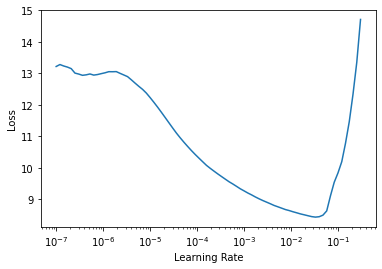

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.136186,3.964236,52.680031,03:53


## Saving the trained model

In [ ]:
# saving the newly trained model
learn.save('1epoch')

Path('models/1epoch.pth')

In [ ]:
# amr
learn.freeze()

In [ ]:
# amr
learn.summary()

CamembertForCausalLM (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 768       
Embedding                                 24580608   True      
Embedding                                 394752     True      
Embedding                                 768        True      
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
Dropout                                                        
Linear                                    590592     True      
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
           

## Saving the model's vocabulary

In [ ]:
# saving the vocabulary
vocab= tokenizer.save_vocabulary('/content/allocine/data/')

NOTE: the file name is `sentencepiece.bpe.model`

In [ ]:
# other way to save the vocabulary by making a list
vocab_lm = list(tokenizer.get_vocab()) #dictionary

In [ ]:
vocab_lm[:10]

['<s>NOTUSED',
 '<pad>',
 '</s>NOTUSED',
 '<unk>',
 '<s>',
 '</s>',
 ',',
 '▁de',
 '.',
 's']

In [ ]:
type(vocab_lm)

list

In [ ]:
len(vocab_lm)

32005

In [ ]:
# vocab size assertion
assert(len(vocab_lm) == tokenizer.vocab_size) # it returns True!

## Inference

In [ ]:
df_valid.head(1)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [ ]:
# testing the language model
prompt = "c'est une histoire abracadabrantesque"

In [ ]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 13])

In [ ]:
# generating predictions
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

NOTE:  `num_beams` makes reference to beam search is a popular search strategy for the sequence to sequence Deep NLP algorithms. It will consider ,multiple alternatives compare to greedy search that will only pickup one most likely word and move on. [beam search algorithm](https://www.youtube.com/watch?v=RLWuzLLSIgw)

`temperature` is a hyperparameter used to control the randomness of predictions by scaling the logits before applying softmax.


In [ ]:
tokenizer.decode(preds[0].cpu().numpy())

"<s> c'est une histoire abracadabrantesque</s>e d'humour et d'action. Un film d'action, d'action, d'action, d'action,"

NOTE: The model 'RobertaForCausalLM' is not supported for text-generation. Supported models are ['XLNetLMHeadModel', 'TransfoXLLMHeadModel', 'ReformerModelWithLMHead', 'GPT2LMHeadModel', 'GPTNeoForCausalLM', 'OpenAIGPTLMHeadModel', 'CTRLLMHeadModel', 'TFXLNetLMHeadModel', 'TFTransfoXLLMHeadModel', 'TFGPT2LMHeadModel', 'TFOpenAIGPTLMHeadModel', 'TFCTRLLMHeadModel']

# Text Classification

In [ ]:
path

Path('/content/allocine')

In [ ]:
df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=30000)
df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [ ]:
# splitting a df by rows
df_train = df.iloc[10001:-1]; len(df_train)

19998

In [ ]:
df_train.to_csv(path/'data/train1.csv', encoding = 'utf-8', header = True, index = False)

In [ ]:
df_train.head(1)

,film-url,review,polarity
10001,http://www.allocine.fr/film/fichefilm-50911/critiques/spectateurs,"Quel navet!!!! Un mix entre une réalisation classique et caméra à l'épaule, des acteurs insupportables (voir la rousse dans la voiture donne une irrésistible envie de gifler), un tueur sans charisme..... Légérement gore qui tâche, aucune sensation de stress ne vient nous titiller l'esprit. Slasher basique sans aucun génie, ce film est à oublier voir même à ne pas regarder. Malgré son 1h10, pas possible de le terminer.",0


## Text Tokenization


In [ ]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [ ]:
print('[CLS] token :', tokenizer.cls_token)
print('[SEP] token :', tokenizer.sep_token)
print('[PAD] token :', tokenizer.pad_token)

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


In [ ]:
tokenizer.pad

<bound method PreTrainedTokenizerBase.pad of PreTrainedTokenizer(name_or_path='camembert-base', vocab_size=32005, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED']})>

In [ ]:
# Transformer Tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return TensorText(self.tokenizer(x, truncation=True)['input_ids'])
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu()))

# Transformer TextBlock
class HFTextBlock(TransformBlock):
    "A `TransformBlock` for texts"
    def __init__(self, tokenizer):
        type_tfms = TransformersTokenizer(tokenizer)
        psd_first = tokenizer.padding_side == 'left'
        #pad_first = tokenizer.padding_side=='left')
        return super().__init__(type_tfms=type_tfms,
                                dl_type= SortedDL,
                                dls_kwargs={'before_batch':Pad_Chunk(pad_idx = tokenizer.pad_token_id, pad_first=(tokenizer.padding_side=='left'))})



NOTE: HFTextBlock is designed to work with vanilla Learner
TransLearner on the other hand expects xb to contain a dictionary (as returned by TokBatchTransform in the example notebook).  So there are 2 passes to take here either use Learner or modify data pipeline. Feel free to ping me here if you choose the second one and need some assistance


## Text Dataloader

In [ ]:
dblock = DataBlock(
        blocks=(HFTextBlock(tokenizer), CategoryBlock),
        get_y=ColReader('polarity'), 
        get_x=ColReader('review'),
        splitter=RandomSplitter()
)

dls_clas = dblock.dataloaders(train_df, bs=16)

In [ ]:
dls_clas.show_batch(max_n=3)

,text,category
0,"<s> Les meilleurs films sont toujours les plus discrets.Preuve en est avec cette pépite franco-espagnole venue de nul part,mettant en scène,et ô combien avec beauté,un vieux garçon paumé et une voisine excentrique et sensuelle.Entre Tati et Almodovar,entre burlesque et onirique,le film de Javier Rebollo est en apparence d'une simplicité extrêmement touchante.Mais bien au-delà de cet amas de scènes routinières aussi pures que belles,""Ce que je sais de Lola"" cache une tendresse rare,une subtilité de ton et un conduit scénaristique franchement splendide.La mise en scène,très calculée,ne nuit pas pour autant à l'aspect reculé du film,et au contraire,on est envoûtés du début à la fin par ses plans sublimes qui riment avec l'esprit du personnage principal,à cette photographie si parfaite et si soignée,à ses contrastes fascinants dignes d'un Johnnie To (si si!) et ses éclairages sournois.Porté tout du long par un acteur épatant de non-dits et d'immobilisme (Michaël Abiteboul) et par la",1
1,"<s> Mon dieu, bijou, je crois qu'on a jamais été aussi proche du vide total, putain dire qu'un film de Bay est vide, qu'un Paranomal Activity c'est de la merde pourrait paraître être de la mauvaise foi lorsqu'on a vu Devil Inside. Je pense que l'on peut sans aucun problème en faire le nouvel maître étalon de la médiocrité. Ce qu'il y a de génial dans ce film c'est qu'il n'y a rien, mais rien du tout à sauver. Déjà il faut le voir en VF, la synchronisation labiale faite par des amateurs, ça vaut le coup d'oeil. Il n'y a pas vraiment de scénario, et c'est encore moins cohérent, genre le prêtre possédé qui arrive à rentrer dans une église et à qui la croix de ne fait rien... C'est juste génial de voir à quel point c'est rien du tout. Je pense qu'on peut se rapprocher avec ce",0
2,"<s> Bravo! Bravo vraiment au cinéma pour ce résultat! Non mais franchement, de qui se moque-t-on? Mon père est femme de ménage long-métrage réalisé par Saphia Azzeddine raconte l'histoire de Polo, un adolescent mal dans sa peau ( comme par hasard ) dont le père est femme de ménage avec qui il va prendre confiance en lui etc... On a l'impression d'avoir vu ce film cent fois. Du déjà-vu, du déjà-vu, du déjà-vu. Le film de la réalisatrice franco-marocaine est navrant de bêtises, d'ignominies, de sornettes. Tout sonne faux dans Mon père est femme de ménage, tout à commencer par la manière dont sont brossés les personnages ( et venant d'une réalisatrice licenciée en sociologie, c'est limite etc ) avec encore une fois l'adolescent mal dans sa peau et le père cool mais aussi une soeur inintéressante, superficielle, inculte et bien-sûr elle est blonde ( tiens, donc ), les amis",0


In [ ]:
print(len(dls_clas.train), len(dls_clas.valid))

500 125


In [ ]:
# number of classes and classes vocab
dls_clas.c, dls_clas.vocab

(2, [0, 1])

## Text Learner

In [ ]:
from transformers import CamembertConfig, CamembertForSequenceClassification

In [ ]:
# del learn

In [ ]:
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

In [ ]:
model_name = "camembert-base"

In [ ]:
model = CamembertForSequenceClassification.from_pretrained(model_name)
learn = Learner(dls_clas, model, loss_func=CrossEntropyLossFlat(), splitter=default_splitter, cbs=[DropOutput], metrics=accuracy).to_fp16() 

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

NOTE: 
- [Fastai Metrics](https://docs.fast.ai/metrics.html)
- [Fastai Loss Functions](https://docs.fast.ai/losses.html)

In [ ]:
learn.model

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0004786300996784121)

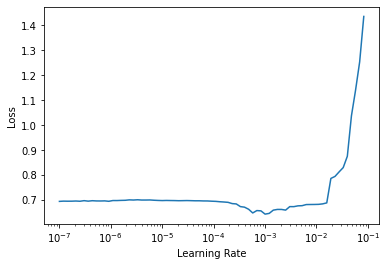

In [ ]:
learn.lr_find()

In [ ]:
bs, sl

(4, 256)

In [ ]:
# number of epochs and learning rate
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.178673,0.178744,0.939500,02:19


In [ ]:
# xb,yb= learn.dls.one_batch()
# xb.shape, yb.shape

In [ ]:
learn.save('1epoch-1e-5')

Path('models/1epoch-1e-5.pth')

In [ ]:
# learn = learn.load('1epoch-1e-5')

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=6.309573450380412e-07)

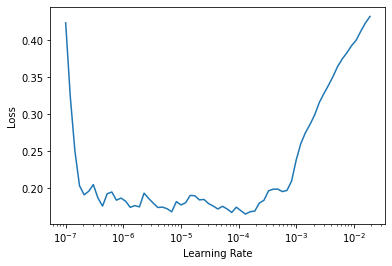

In [ ]:
learn.lr_find()

In [ ]:
# gradual unfreezing - unfreezing the last couple of layer groups
learn.freeze_to(-2)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.121206,0.140775,0.946500,02:17


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=6.309573450380412e-07)

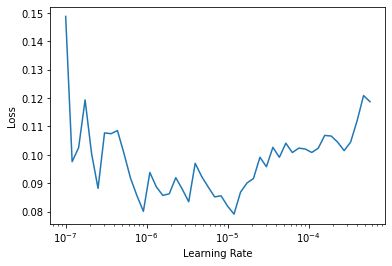

In [ ]:
learn.lr_find()

In [ ]:
# gradual unfreezing - unfreezing the last three of layer groups
learn.freeze_to(-3)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.118712,0.130382,0.956000,02:19


In [ ]:
# unfreezing
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

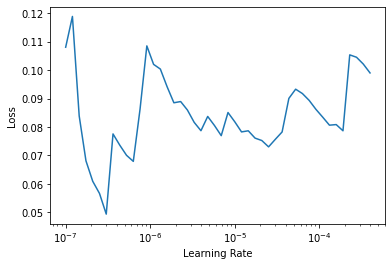

In [ ]:
learn.lr_find()

In [ ]:
# using discriminative learning rates
learn.fit_one_cycle(2, slice(1e-5/(2.6**4),1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.071272,0.139994,0.955500,02:20
1,0.068519,0.141356,0.955500,02:20


In [ ]:
learn.save(path/"models/finetuned")

Path('/content/allocine/models/finetuned.pth')

## Evaluate

In [ ]:
# amr predicting sentiment analysis
learn.predict("Ce film est vraiment marrant")

('1', tensor(1), tensor([0.0026, 0.9974]))

In [ ]:
# amr predicting sentiment analysis
learn.predict("Ce film est un navet")

('0', tensor(0), tensor([0.9985, 0.0015]))

In [ ]:
learn.show_results()

,text,category,category_
0,"<s> Alors là les amis, je sors mon couteau de cuisine électrique 12 vitesses pour hacher menu cet opus minimaliste, pour lequel le scénario tient sur un ticket de métro ( et encore, déjà composté). Laure Marsac est bien jolie, pas de problème, elle apprend à conduire laborieusement, passe encore, mais l'INTERMINABLE ( avec ""INTER"" en bonus cadeau ndlr) séquence sur le parking du CORA est impressionnante de vacuité, de nombrilisme et m'a atterré ( je n'ai pas dit enterré). Au secours, halte-là Robin des Bois, on arrête la tequila et on ne fume plus son tapis persan, mais quand je lis les critiques entendues et parisiennes de mes chers Inrocks, Libé, Télerama ou le Monde, je tombe de ma chaise. Il ne se passe rien, c'est une déclinaison du néant à tous les temps. De plus, chez Renault, ont-ils écrit une lettre de prostestation pour signifier qu'il est IMPOSSIBLE",0,0
1,"<s> Oulah... Je suis fana d'avion - et pilote pro - et j'ai regardé ce film parce que je suis super bon public dès que l'histoire tourne là autour. Mais là, l'avion n'est visiblement que le prétexte pour faire des économies de décor. Tout est faux, autant au niveau aéronautique (chaque scène comporte une erreur; j'ai arrêté de compter à une vingtaine d'aberrations) que dans le jeu des acteurs, dans le scénario ou dans les effets ""spéciaux"" à deux balles. Un des pires navets que j'aie jamais vus. Ce serait juste amusant de lancer un concours de qui trouvera le plus d'erreurs techniques, de vol ou de scénario. Allez, juste pour les quelques premières minutes: - pendant le roulage avant décollage, la manette rouge (mixture) est complètement en arrière. Cela signifie donc que le moteur est arrêté... - l'avion pénètre sur la piste et s'aligne (normal) puis, quand l'autorisation de",0,0
2,"<s> Je ne serais sans doutes jamais aller voir ce film si les circonstances ne m'y avaient contraint. Séance familiale de rattrapage (le film est sorti il y a 4 mois) oblige. Je découvre ""La Famille Bélier"" au cinéma à l'heure où celui-ci est déjà sorti en DVD et Blu-Ray! Ce film ne m'attirait pas spécialement. Sur le papier, l'histoire de Paula, seule ""entendante"" d'une famille de sourds, qui, pour couronner le tout, se voit dotée d'une voix magnifique par un Créateur plus indescriptible que jamais sentait l'air frais, mais le tout traité sous forme de comédie par Eric Lartigau, avec pour vedette une ancienne de The Voice, cela pouvait paraître... comment dire... incongru? Nauséabond? Mais en même temps il y avait François Damiens et Karin Viard et puis la bande-annonce était assez sobre et promettait un truc sympa. Fifty-fifty donc. En gros : au ciné je verrais quand temps",1,1
3,"<s> Allo maman c'est Noël : J’ai halluciné quand j’ai vu par hasard dans un magasin de dvd qu’il y avait un troisième épisode... Cela a du marché à l’époque pour qu’ils fassent encore une suite. Car le premier était surprenant mais bien, le deuxième la surprise était moins la mais c’était sympathique. Alors pour ce troisième opus, je vous avouerez que j’y vais à reculons et je crains le pire. Et la, grand surprise car on a le droit au meilleur de la série, vraiment le mieux des trois. Puisque c’est une vraie comédie familiale, très amusant avec de très bon gags, le gout de animaux qui parlent au début est encore une fois surprenant et on s’attend au pire mais ça passe crème et c’est que l’idée est très bien intégré et sans rend le tout super attachant, ça fait un peu comme dans Beethoven. Et on a",1,1
4,"<s> Après le catastrophique ""Iron man 2"", j'esperais que le prochain essai de Jon Favreau serait le bon. Surtout que ce ""Cow boys and Aliens"" était un projet qui me donnait l'eau à la bouche. mélangé deux de mes genres préférés, qui ont forgé ma cinéphilie... un rêve de fou. Surtout que je n'attendais même pas une métaphore sur la guerre ou l'ouest sauvage, juste un bon blockbuster, des anti héros charismatiques à la Sergio Leone, des panoramas à la John Ford mixé a

In [ ]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

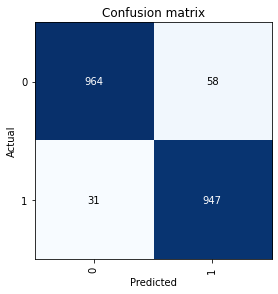

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

,input,target,predicted,probability,loss
0,"<s> ""Libero""est le meilleur exemple de la renaissance du cinéma italien.Drame familial proche du thème de ""la chambre du fils"",il traduit très bien la complexité des rapports entre un enfant de 11 ans introverti et son père colérique et généreux.Une famille monoparentale qui ne peut tenir que par l'amour et les attentions les uns envers les autres.Tableau vivant très réaliste sur l'ouverture au monde extérieur lors de la pré-adolescence.Encore une fois,le film est d'une grande qualité.Ma note correspond juste à mon ressenti personnel.Histoire de gout en fait.Ceci étant dit,la pudeur et la justesse de cette histoire font affleurer l'émotion.Pas si courant de nos jours.</s>",0,1,0.9984632730484009,6.478100299835205
1,"<s> Trés Trés long à démarrer, mais les quelques scènes de combats sont à couper le souffle... Un scénario complètement bidon, des dialogues pourries.. mais c'est pas ce qu'on recherche dans ce film, vous voulez voir des vrais combat? regardez Flashpoint!</s>",1,0,0.9984602928161621,6.4761505126953125
2,<s> Un garçon dans l'errance qui apprend à devenir adulte à défaut d'avoir une mère responsable. Peu de dialogues et une mise en scène sobre pour un film corps-à-corps!</s>,1,0,0.99826580286026,6.357204437255859
3,"<s> Tout simplement l'adaptation de Batman la plus scandaleuse jamais produite au cinéma. Vu qu'on aime le scandale, on adore. Tout n'est qu'aberration, kitch, gags ineptes, avec des personnages plus pathétiques les uns que les autres. The Dark Kight, c'est une bouse à côté de ça! Faut le voir, les gars! Je vous jure que vous ne verrez plus Batman de la même façon... Le plus scandaleux doit être la dédicace au public en début de film. Que du bonheur...</s>",1,0,0.9977127313613892,6.080414772033691
4,"<s> Vraiment hilarant, surtout les scènes avec Chabal.</s>",0,1,0.99703049659729,5.819380283355713
5,"<s> Un divertissement pur et dur, écrit avec les pieds mais mis en scène agréablement! Enfin quitté à voir du viking autant remater ""Le guerrier silencieux""!</s>",0,1,0.9964893460273743,5.651954174041748
6,"<s> 11 critiques pour ce film dont 7 négatives, au moment où j'écris ces lignes. J'ai lu entr'autres: ""Angie Harmon nous joue la psycho avec un ridicule certain en cabotinant comme une folle, elle n'est pas une grande actrice ça c'est sûr"" ou ""Un gros gros navet des jardins fleuris!"" et puis aussi ""Mais le gros bug, c'est que c'est impossible qu'une mère puisse tuer autant d'enfant sans que la police n'y prête pas attention!"" & la meilleure pour la route ""Quelques scènes horribles, insoutenables"". Ridicule pour la dernière remarque mais pas faux pour l'avant dernière remarque, mais il faut se vider la tête avant de regarder un film. Y'a une place qui vous attend dans les canards parisiens car vous êtes dignes de succéder à tous ces imbéciles de critiques qui ont toujours voulu se faire remarquer en mettant des zéros pointés. Pour Angie Harmon, c'est navrant car c'est",1,0,0.9953814744949341,5.377676010131836
7,<s> Un film au casting qui attire l'attention avec un Grand Kevin Kosner et ma chère Jennifer Aniston! J'ai bien aimé ce film bien que l'histoire pourrait déplaire à pas mal de gens! Kevin Kosner fidèle à lui même y incarne un séducteur qui semble s'accrocher aux femmes d'une même famille qui finissent toutes dans ses bras! Sympathique et agréable à regarder!</s>,0,1,0.9938070178031921,5.08433723449707
8,"<s> c'est leeeeeeeeeeent! j'aime le travail de Godfrey Reggio et de Philip Glass, mais a l'inverse de la trilogie des qatsi, ce travail a plus de sens sous la forme de livre/expo photo que de réel film de... 1h27?! même Magnolia de P.T.A qui fait ( je le rappel) plus de 3h m'a paru moins long!</s>",0,1,0.9937950372695923,5.082396030426025


# Additional Resources
[Language Processing With BERT](https://www.youtube.com/watch?v=ioGry-89gqE)

[The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning](http://jalammar.github.io/illustrated-bert/)

[Transfer Learning](https://youtu.be/BqqfQnyjmgg)

[SMART: Robust and Efficient Fine-Tuning for Pre-trained Natural Language Models through Principled Regularized Optimization](https://arxiv.org/abs/1911.03437)

[Wu Dao 2.0: A Monster of 1.75 Trillion Parameters](https://towardsdatascience.com/gpt-3-scared-you-meet-wu-dao-2-0-a-monster-of-1-75-trillion-parameters-832cd83db484)



